![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [96]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
# read in the csv file
df = pd.read_csv('rental_info.csv',
                     parse_dates = ['rental_date', 'return_date'])
print(df.shape)
print(df.columns)
print(df.info())
df.head()

(15861, 15)
Index(['rental_date', 'return_date', 'amount', 'release_year', 'rental_rate',
       'length', 'replacement_cost', 'special_features', 'NC-17', 'PG',
       'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64          

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [98]:
# Create "rental_length_days" col using the "return_date" and "rental_date" cols
df["rental_length_days"] = df["return_date"] - df["rental_date"]
df["rental_length_days"] = df["rental_length_days"].dt.total_seconds() / (60 * 60 * 24)
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.865278
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.836806
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7.238889
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.100000
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4.045139


In [99]:
# create deleted_scenes and behind_the_scenes cols
df["deleted_scenes"] = df["special_features"].apply(lambda x: 1 if "Deleted Scenes" in x else 0)
df["behind_the_scenes"] = df["special_features"].apply(lambda x: 1 if "Behind the Scenes" in x else 0)
df.head(10)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.865278,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.836806,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7.238889,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.100000,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4.045139,0,1
5,2005-05-29 16:51:44+00:00,2005-06-01 21:43:44+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.202778,0,1
6,2005-06-17 19:42:42+00:00,2005-06-22 20:39:42+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,5.039583,0,1
7,2005-07-09 18:23:46+00:00,2005-07-13 19:04:46+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4.028472,0,1
8,2005-07-27 13:16:28+00:00,2005-07-28 13:40:28+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,1.016667,0,1
9,2005-08-21 13:53:52+00:00,2005-08-25 09:03:52+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.798611,0,1


## Data leakage

+ The `amount` is determined ***after*** the DVD has been returned. In other word, `amount` is determined by the target `rental_length_days` and not the other way around therefore the `amount` feature *leaks* information about the target (`rental_length_days`), so it should **NOT** be used as a predictor.
+ For the same reason that `amount` should not be used, `amount_2` (the square of `amount`) should not be used either.
+ Notice the correlation between `amount` and `rental_length_days` and the corresponding scatter plot below.

Correlation between rental length and amount: 0.5573509800734001


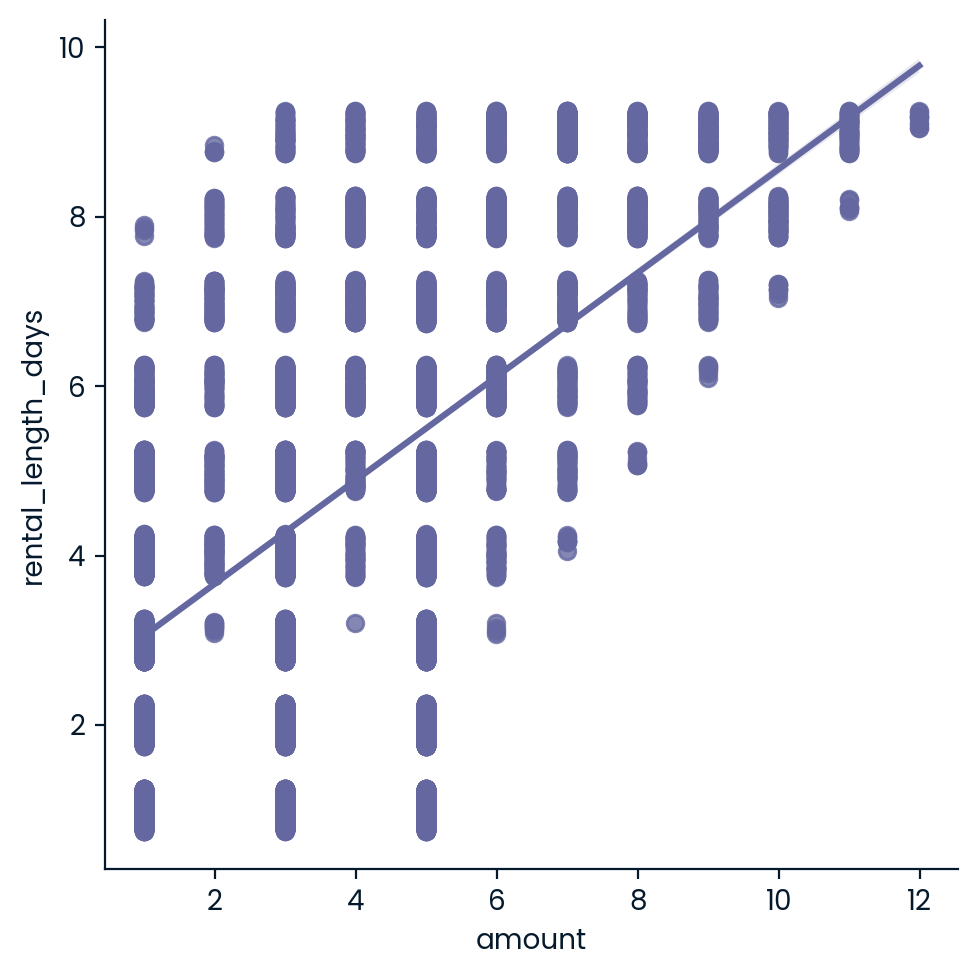

In [100]:
length_amount_corr =df['amount'].corr(df['rental_length_days'])
print(f"Correlation between rental length and amount: {length_amount_corr}")

sns.lmplot(data=df, x='amount', y='rental_length_days')
plt.show()

## Baseline model: target mean

The simplest model we could use to predict rental length is simply the mean of the training data. This will serve as our baseline.

In [101]:
# create initial feature matrix
init_feature_cols = ['rental_rate', 'rental_rate_2', 'release_year', 'length', 'length_2',
                    'replacement_cost', 'NC-17', 'PG', 'PG-13', 'R', 'deleted_scenes', 'behind_the_scenes']
X_01 = df[init_feature_cols]
# specify the target
y = df['rental_length_days']

In [102]:
# split into train and test sets
SEED = 9
X_train, X_test, y_train, y_test = train_test_split(X_01, y,
                                                    test_size=0.2,
                                                    random_state=SEED)
print(f"Training feature matrix shape: {X_train.shape}, Testing feature matrix shape: {X_test.shape}")
print(f"Training target vector shape: {y_train.shape}, Testing target vector shape: {y_test.shape}")

Training feature matrix shape: (12688, 12), Testing feature matrix shape: (3173, 12)
Training target vector shape: (12688,), Testing target vector shape: (3173,)


In [103]:
mean_target_train = y_train.mean()
square_errors = (y_test - mean_target_train) ** 2
mse_mean_target_model = square_errors.mean()
print(f"Mean target model prediction = {mean_target_train:.2f}")
print(f"MSE target mean model = {mse_mean_target_model:.2f}")

Mean target model prediction = 5.03
MSE target mean model = 6.82


## Exploratory Data Analysis (EDA)

### Categorical predictors

Taking a look at how each categorical feature relates to the target, we see that:

1. Rental rate by itself shows no significant impact on rental length
2. Moving rating ('NC-17', 'PG', 'PG-13', 'R' or NOT RATED) by itself shows no significant impact on rental length
3. Whether special content is either included or not, by itself shows no significant impact on rental length

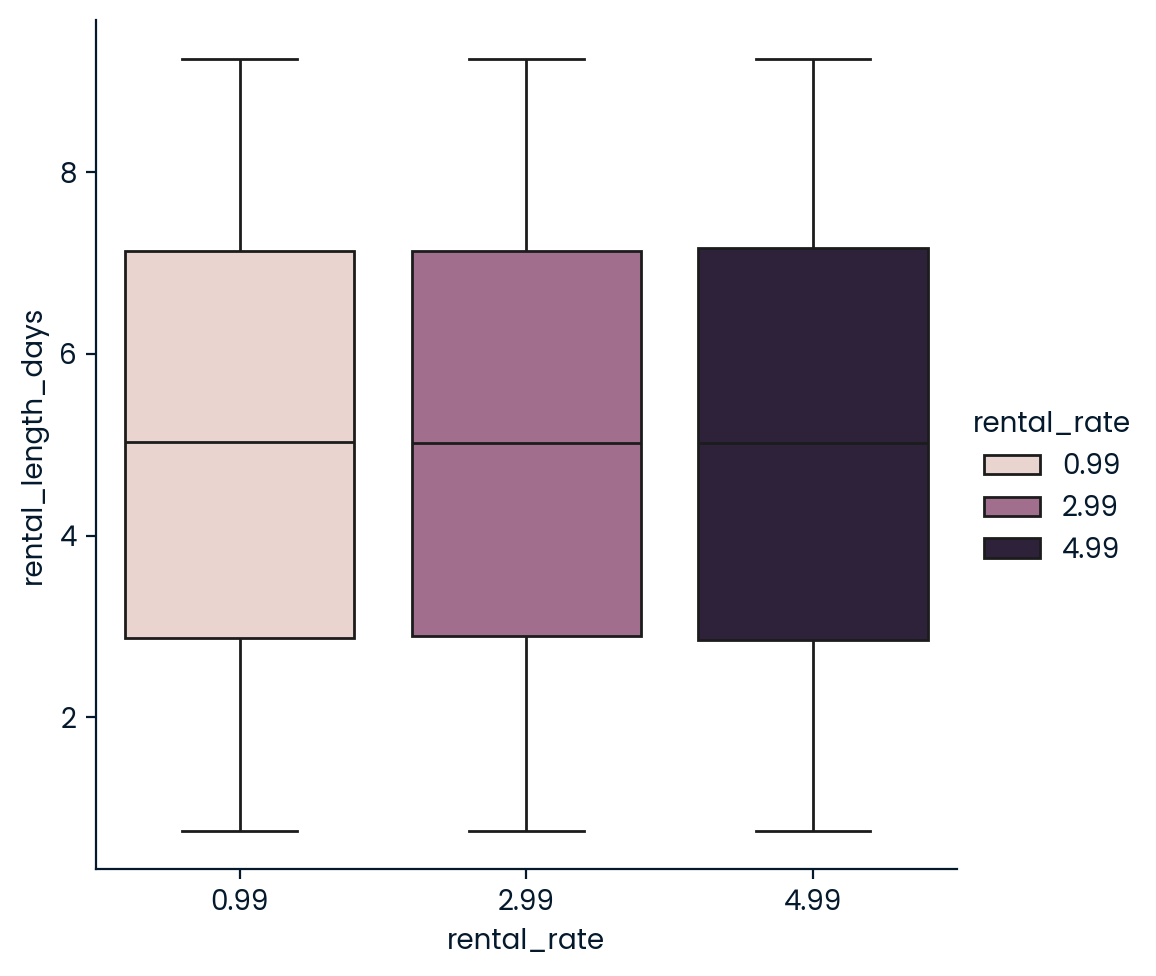

In [104]:
gx = sns.catplot(x='rental_rate',
                 y='rental_length_days',
                 data=df,
                 kind='box',
                 hue='rental_rate')

plt.show()

In [105]:
# Are the means of the returns the same for each rental rate? ANOVA suggests YES,
# so probably NOT a good predictor...
alpha = 0.2

pingouin.anova(data=df,
               dv="rental_length_days", between="rental_rate")

,Source,ddof1,ddof2,F,p-unc,np2
0,rental_rate,2,15858,0.02411,0.976178,0.000003


In [106]:
binary_feats = ['NC-17', 'PG', 'PG-13', 'R', 'deleted_scenes', 'behind_the_scenes']
df_rated = df.loc[:, ['NC-17', 'PG', 'PG-13', 'R', 'rental_length_days']]
df_rated.loc[:, 'R'] = df_rated['R'] * 4
df_rated.loc[:, 'PG-13'] = df_rated['PG-13'] * 3
df_rated.loc[:, 'PG'] = df_rated['PG'] * 2
# leave NC-17 as 0 or 1
df_rated['rated_index'] = df_rated['NC-17'] + df_rated['PG'] + df_rated['PG-13'] + df_rated['R']

def convert_rated(rate_index):
    if rate_index == 4:
        return 'R'
    elif rate_index == 3:
        return 'PG-13'
    elif rate_index == 2:
        return 'PG'
    elif rate_index == 1:
        return 'NC-17'
    else:
        return 'NOT RATED'

df_rated['rated'] = df_rated['rated_index'].apply(lambda x: convert_rated(x))

In [107]:
df_rated['rated'].value_counts()

PG-13        3543
NC-17        3249
PG           3177
R            3152
NOT RATED    2740
Name: rated, dtype: int64

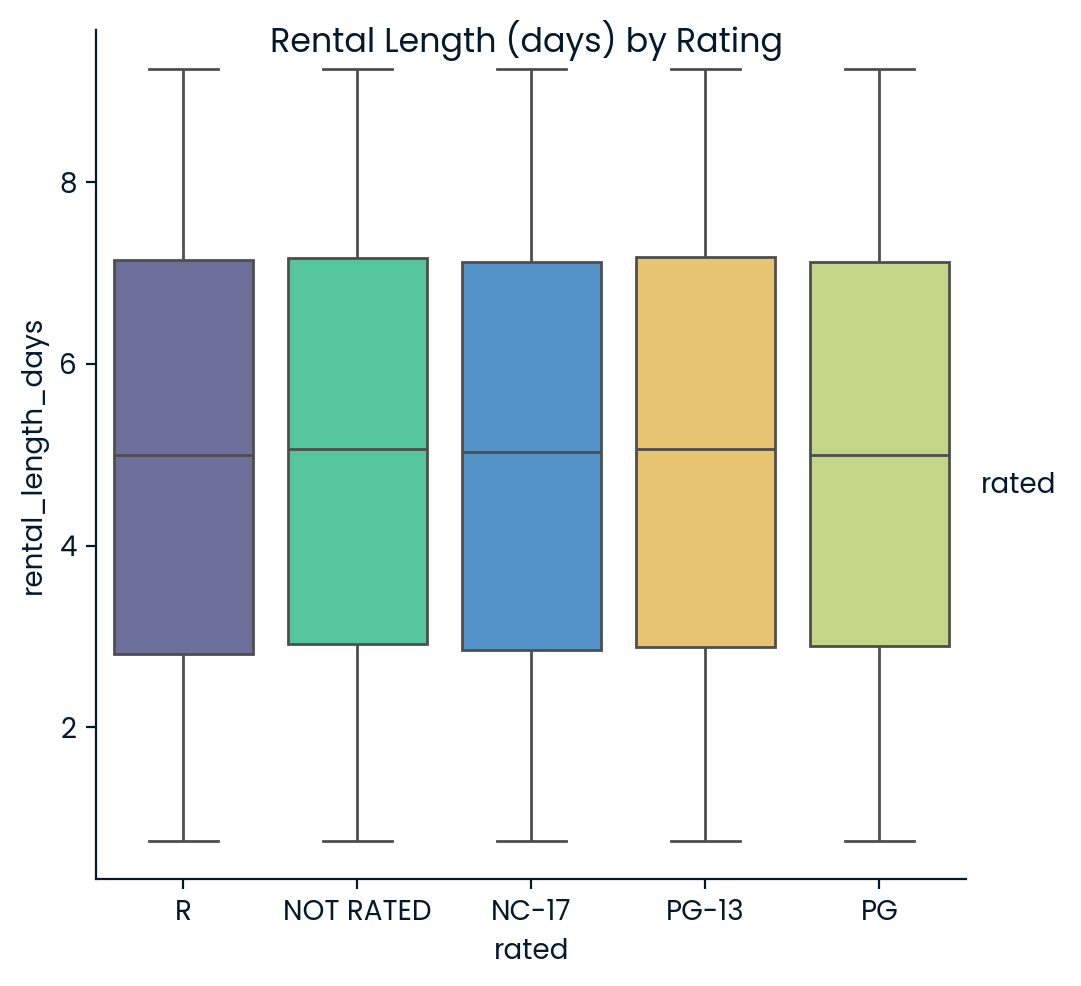

In [108]:
g1 = sns.catplot(x='rated',
                y='rental_length_days',
                data=df_rated,
                kind='box',
                hue='rated')
g1.fig.suptitle("Rental Length (days) by Rating")
plt.show()

(array([360., 344., 341., 308., 242., 234., 300., 366., 343., 339.]),
 array([0.75      , 1.59986111, 2.44972222, 3.29958333, 4.14944444,
        4.99930556, 5.84916667, 6.69902778, 7.54888889, 8.39875   ,
        9.24861111]),
 <BarContainer object of 10 artists>)

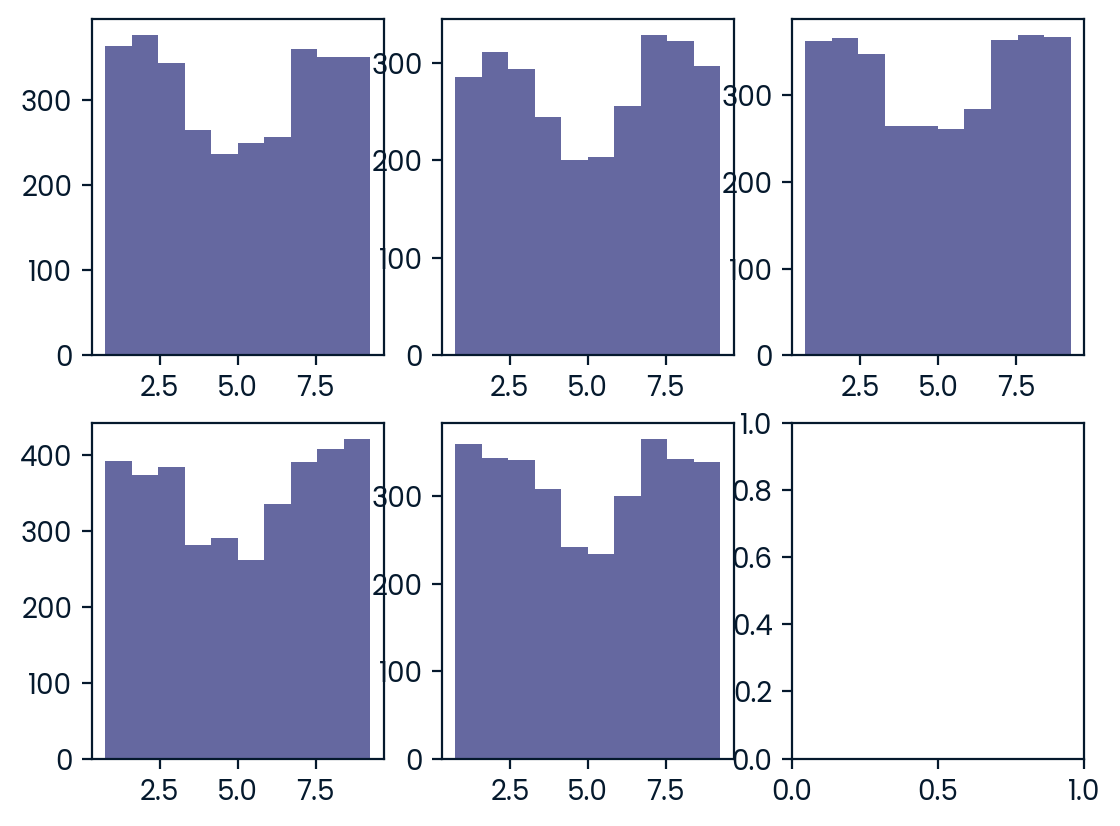

In [109]:
# how do return times distribute within each rating category?
fig, ax = plt.subplots(2, 3)
ax[0, 0].hist(df_rated.loc[df_rated['rated'] == 'R', 'rental_length_days'])
ax[0, 1].hist(df_rated.loc[df_rated['rated'] == 'NOT RATED', 'rental_length_days'])
ax[0, 2].hist(df_rated.loc[df_rated['rated'] == 'NC-17', 'rental_length_days'])
ax[1, 0].hist(df_rated.loc[df_rated['rated'] == 'PG-13', 'rental_length_days'])
ax[1, 1].hist(df_rated.loc[df_rated['rated'] == 'PG', 'rental_length_days'])

In [110]:
# Are the means of the returns the same for each movie rating? ANOVA suggests YES,
# so probably NOT a good predictor...
import pingouin

alpha = 0.2

pingouin.anova(data=df_rated,
               dv="rental_length_days", between="rated")

,Source,ddof1,ddof2,F,p-unc,np2
0,rated,4,15856,0.986765,0.413251,0.000249


In [111]:
df_specials = df.loc[:, ['deleted_scenes', 'behind_the_scenes', 'rental_length_days']]
df_specials['special_index'] = df_specials['deleted_scenes'] + (2 * df_specials['behind_the_scenes'])

def convert_specials(s):
    if s == 3:
        return 'both_deleted_and_behind_scenes'
    elif s == 2:
        return 'behind_scenes_only'
    elif s == 1:
        return 'deleted_scenes_only'
    else:
        return 'neither_deleted_or_behind_scenes'

df_specials['specials'] = df_specials['special_index'].apply(lambda x: convert_specials(x))

df_specials['specials'].value_counts()

behind_scenes_only                  4616
deleted_scenes_only                 3997
both_deleted_and_behind_scenes      3891
neither_deleted_or_behind_scenes    3357
Name: specials, dtype: int64

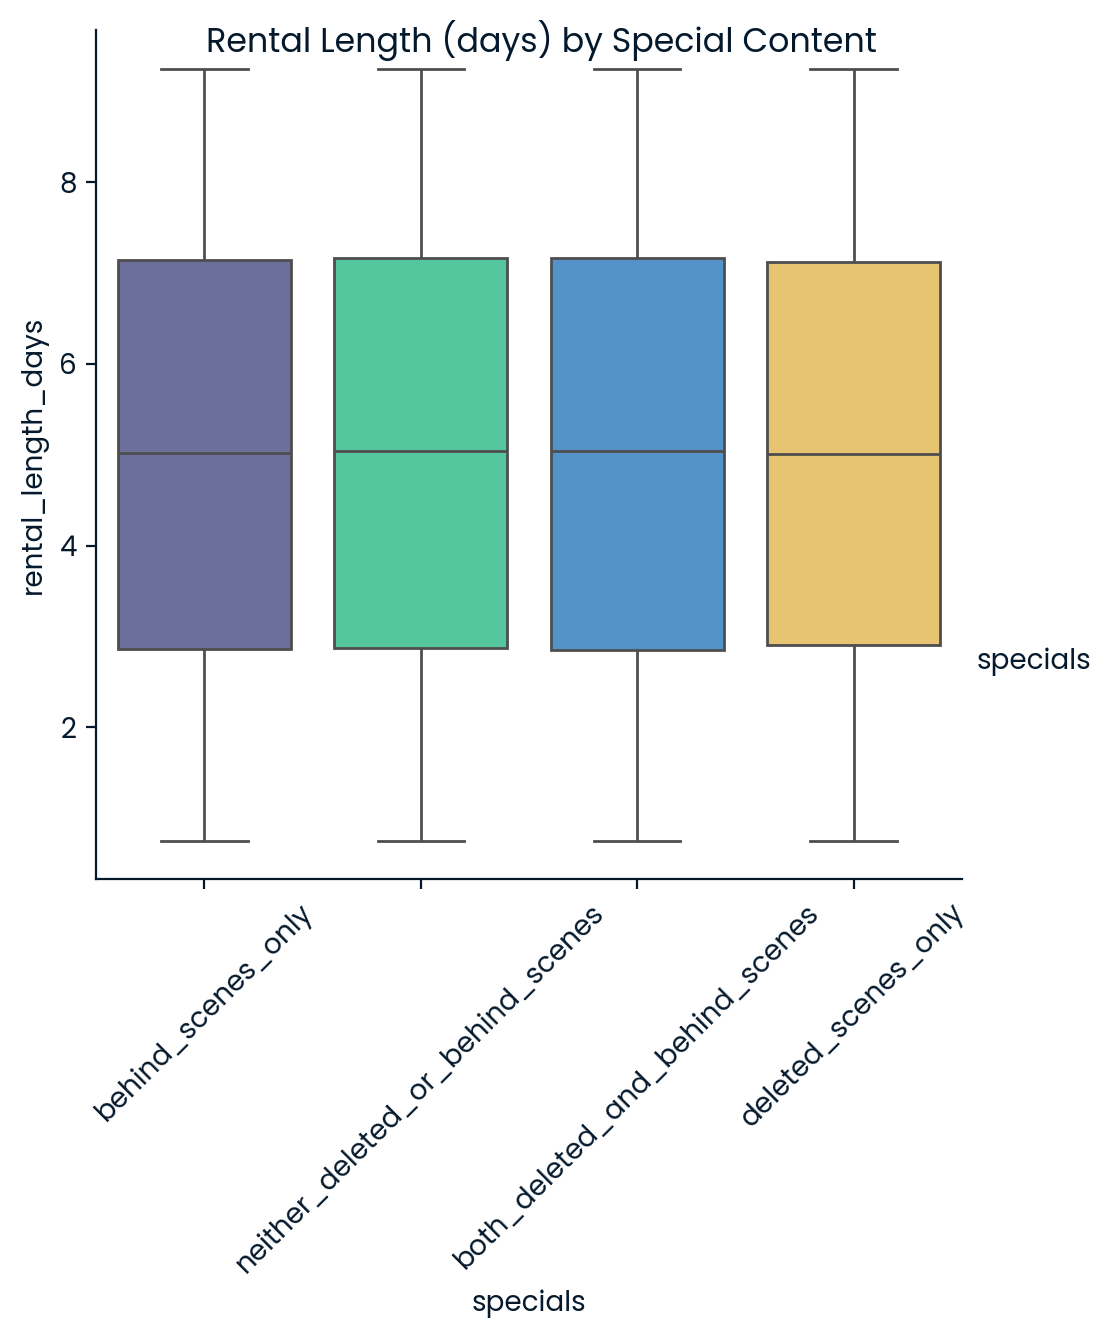

In [112]:
g2 = sns.catplot(x='specials',
                 y='rental_length_days',
                 data=df_specials,
                 kind='box',
                 hue='specials')
g2.fig.suptitle("Rental Length (days) by Special Content")
plt.xticks(rotation=45)
plt.show()

(array([347., 382., 388., 289., 247., 266., 300., 359., 384., 395.]),
 array([0.75138889, 1.60083333, 2.45027778, 3.29972222, 4.14916667,
        4.99861111, 5.84805556, 6.6975    , 7.54694444, 8.39638889,
        9.24583333]),
 <BarContainer object of 10 artists>)

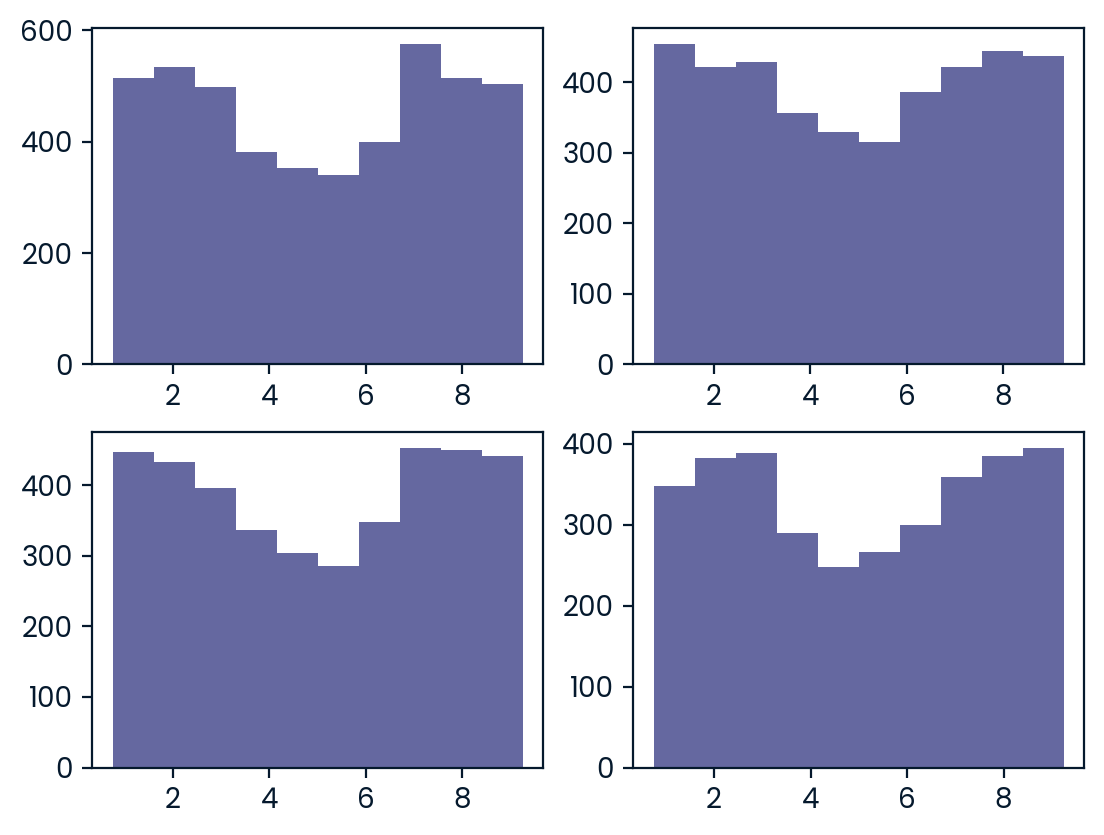

In [113]:
# how do return times distribute within each specials category?
fig, ax = plt.subplots(2, 2)

ax[0, 0].hist(df_specials.loc[df_specials['specials'] == "behind_scenes_only", 'rental_length_days'])
ax[0, 1].hist(df_specials.loc[df_specials['specials'] == "deleted_scenes_only", 'rental_length_days'])
ax[1, 0].hist(df_specials.loc[df_specials['specials'] == "both_deleted_and_behind_scenes", 'rental_length_days'])
ax[1, 1].hist(df_specials.loc[df_specials['specials'] == "neither_deleted_or_behind_scenes", 'rental_length_days'])

In [114]:
# gy = sns.lmplot(data=df_raw,
#                 x='replacement_cost',
#                 y='rental_length_days')

# plt.show()

In [115]:
# Are the means of the returns the same for each movie with special content? ANOVA suggests YES,
# so probably NOT a good predictor...
alpha = 0.2

pingouin.anova(data=df_specials,
               dv="rental_length_days", between="specials")

,Source,ddof1,ddof2,F,p-unc,np2
0,specials,3,15857,0.253176,0.859119,0.000048


## Continuous features

+ `replacement_cost` has a small but significant impact on rental length
+ `release_year` by itself has no significant impact on rental length
+ `length` of a movie by itself has no significant impact on rental length

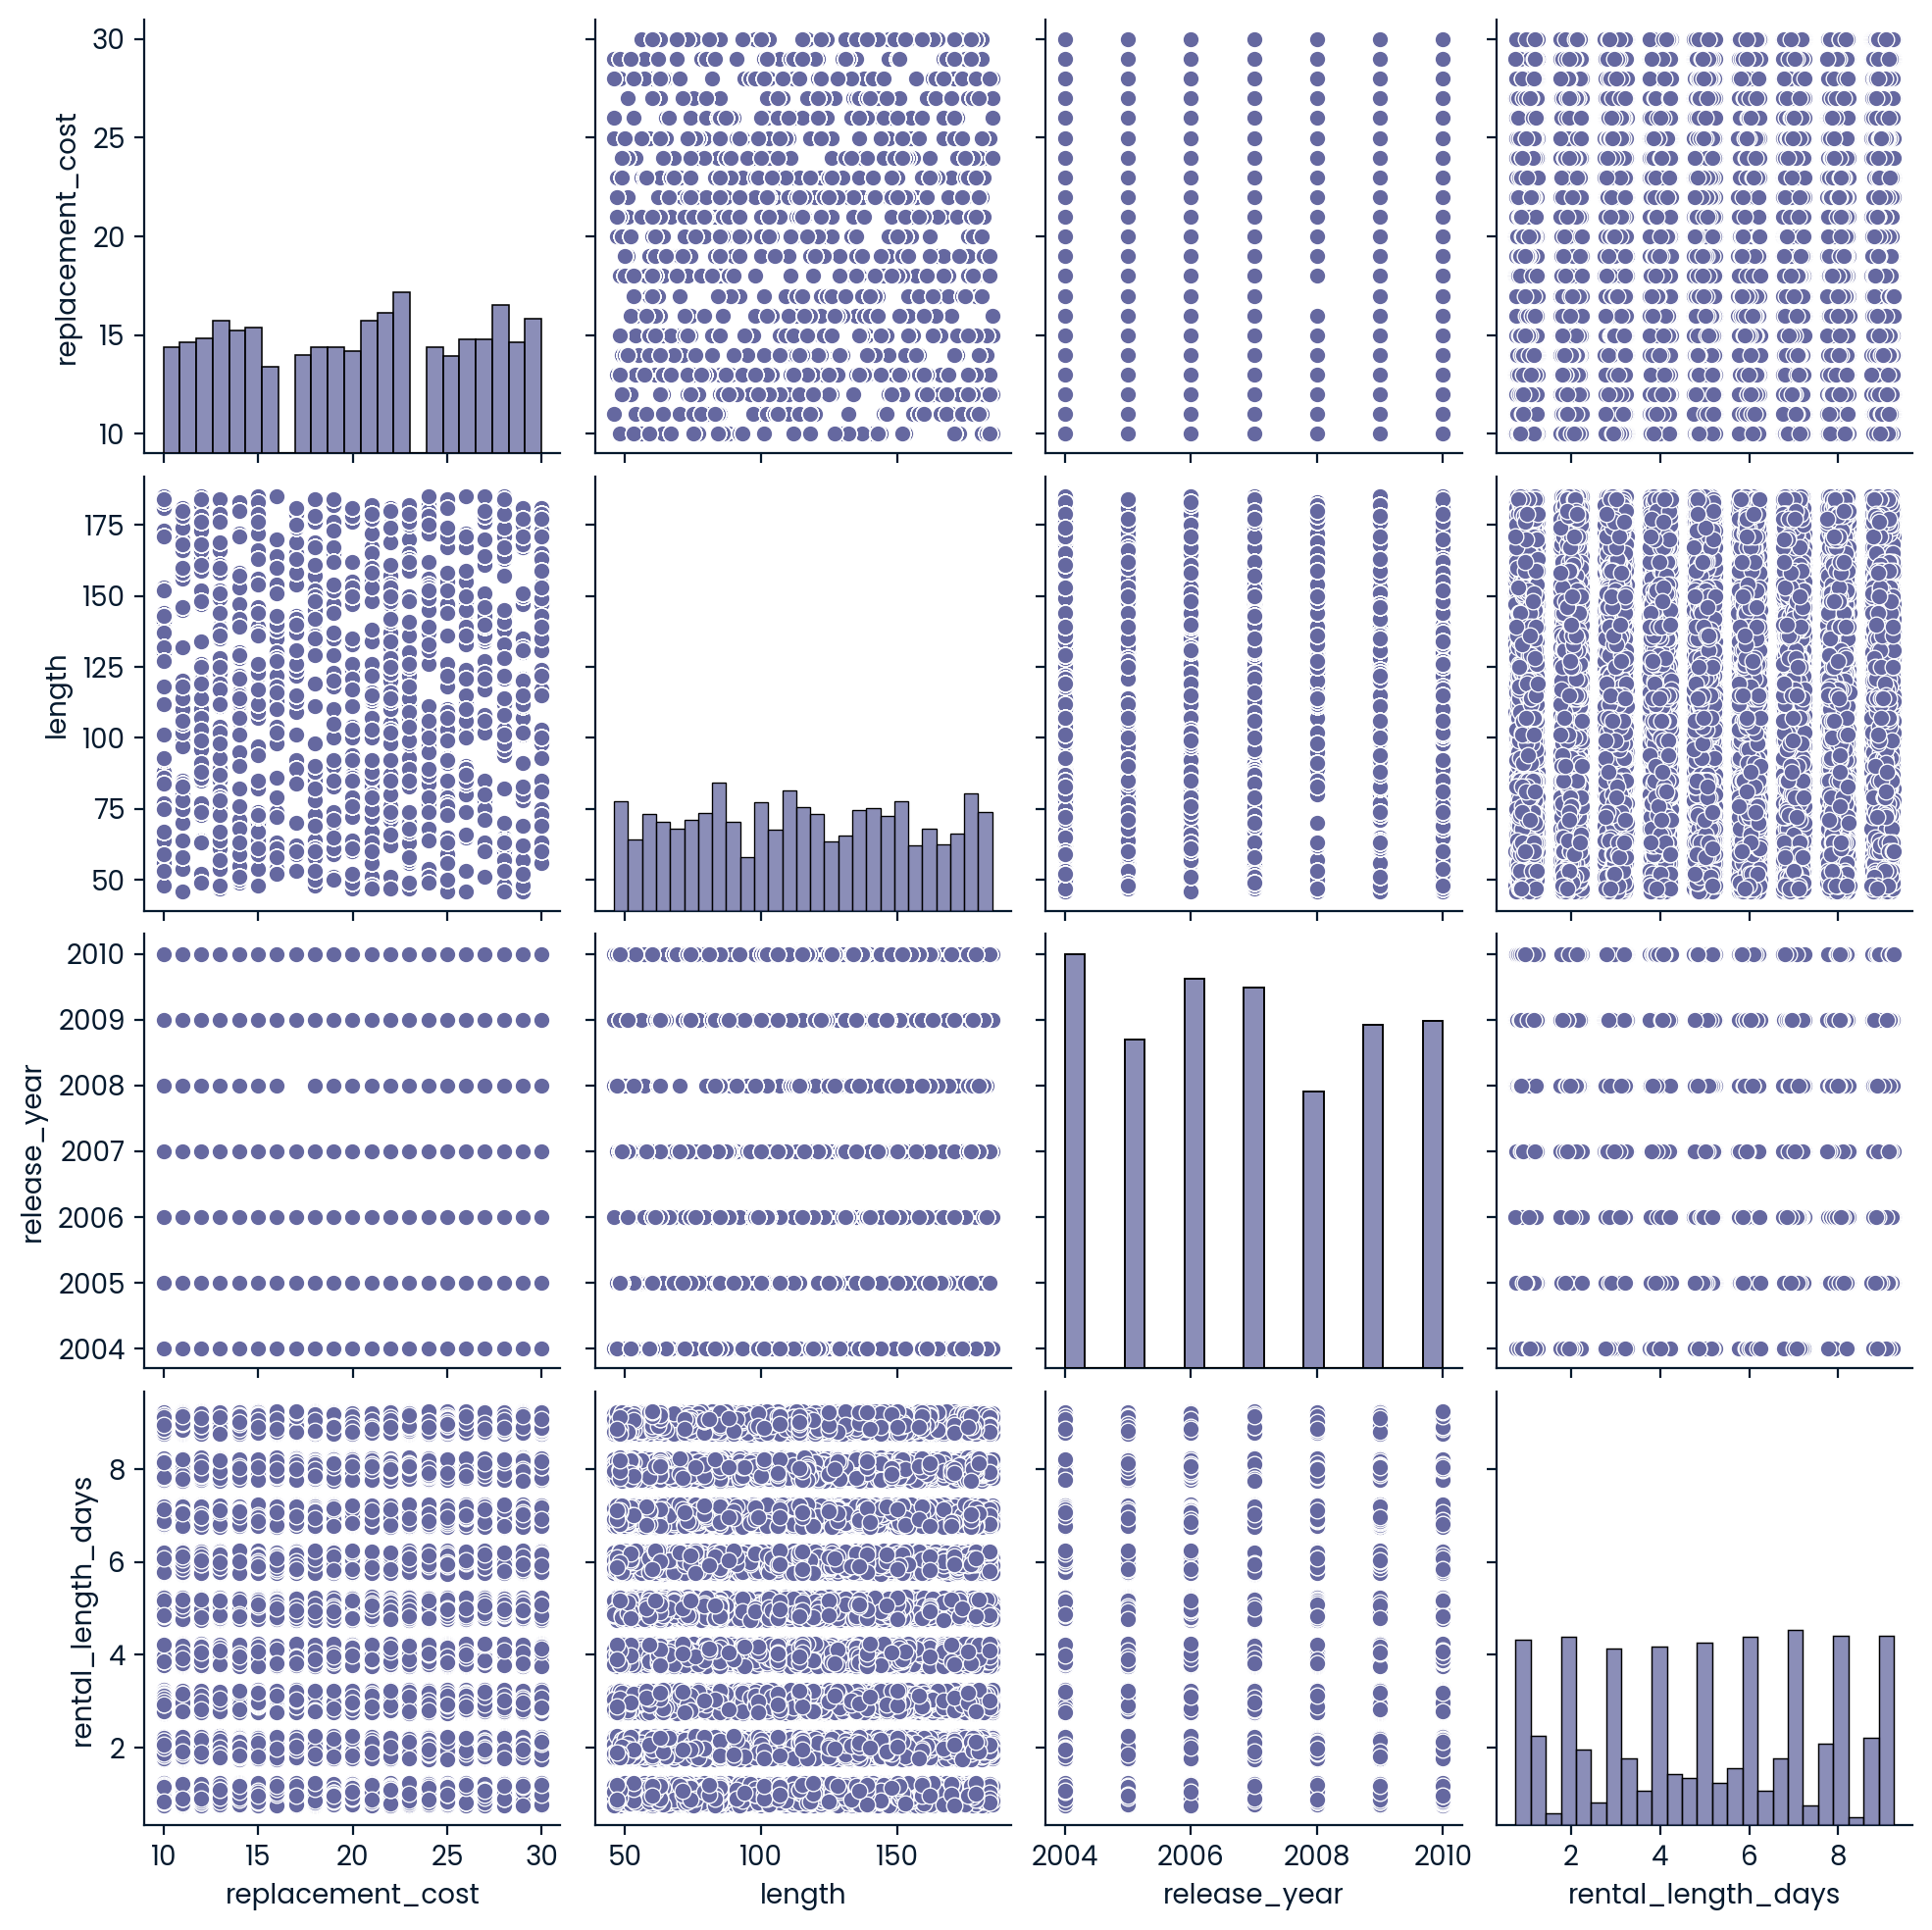

In [116]:
#                                                                vvvvv target vvvvv
pair_plot_cols = ['replacement_cost', 'length', 'release_year', 'rental_length_days']

sns.pairplot(df[pair_plot_cols], diag_kind="hist")
plt.show()

                            OLS Regression Results                            
Dep. Variable:     rental_length_days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.666
Date:                Fri, 08 Aug 2025   Prob (F-statistic):             0.0308
Time:                        19:52:56   Log-Likelihood:                -37609.
No. Observations:               15861   AIC:                         7.522e+04
Df Residuals:                   15859   BIC:                         7.524e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.8776      0.071  

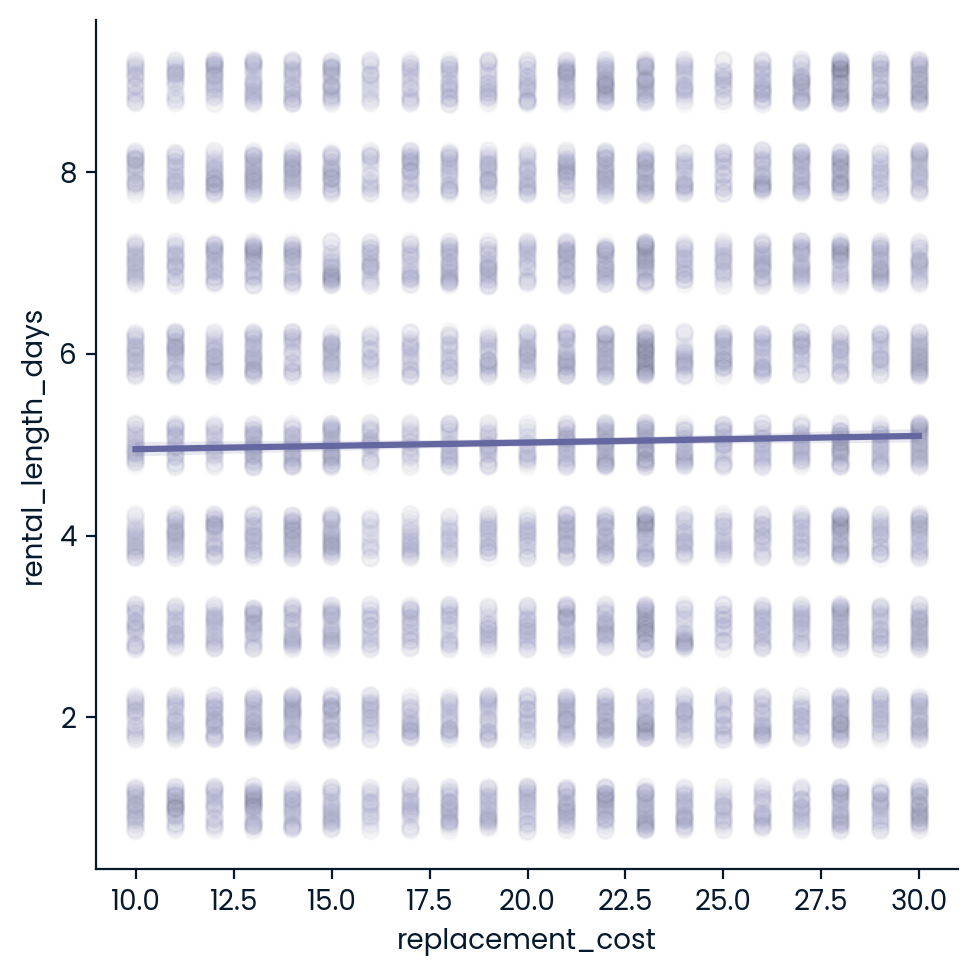

In [117]:
# does replacement cost have a significant impact on rental length? Yes, but it's small
import statsmodels.formula.api as smf
model_replacement_cost = smf.ols('rental_length_days ~ replacement_cost', data=df)
model_replacement_cost_fit = model_replacement_cost.fit()
print(model_replacement_cost_fit.summary())  # slope is small, but significant

g_replace = sns.lmplot(data=df,
                       x='replacement_cost',
                       y='rental_length_days',
                       scatter_kws={'alpha':0.01})

plt.show()

                            OLS Regression Results                            
Dep. Variable:     rental_length_days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7294
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.393
Time:                        19:52:57   Log-Likelihood:                -37611.
No. Observations:               15861   AIC:                         7.523e+04
Df Residuals:                   15859   BIC:                         7.524e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -12.3948     20.397     -0.608   

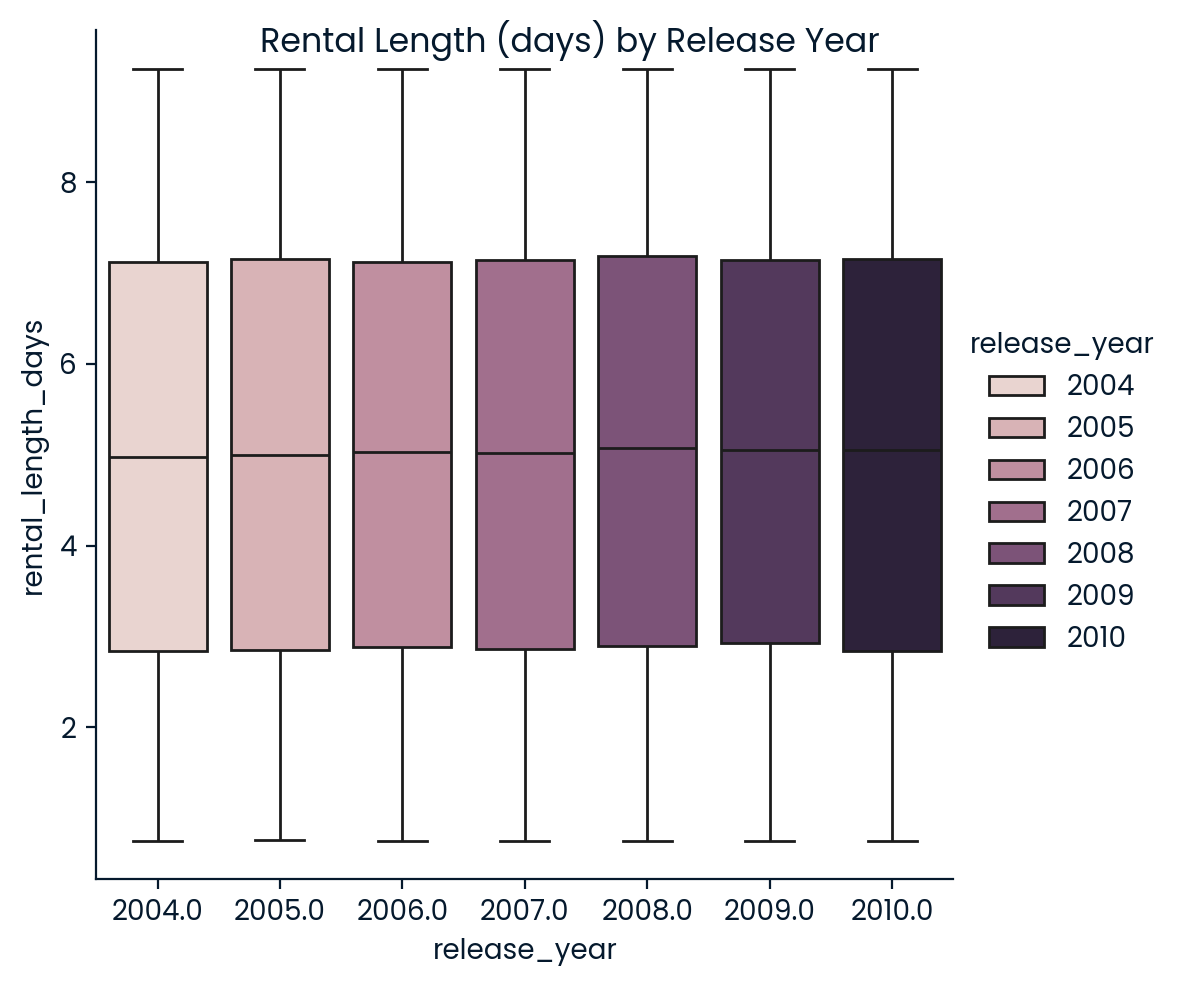

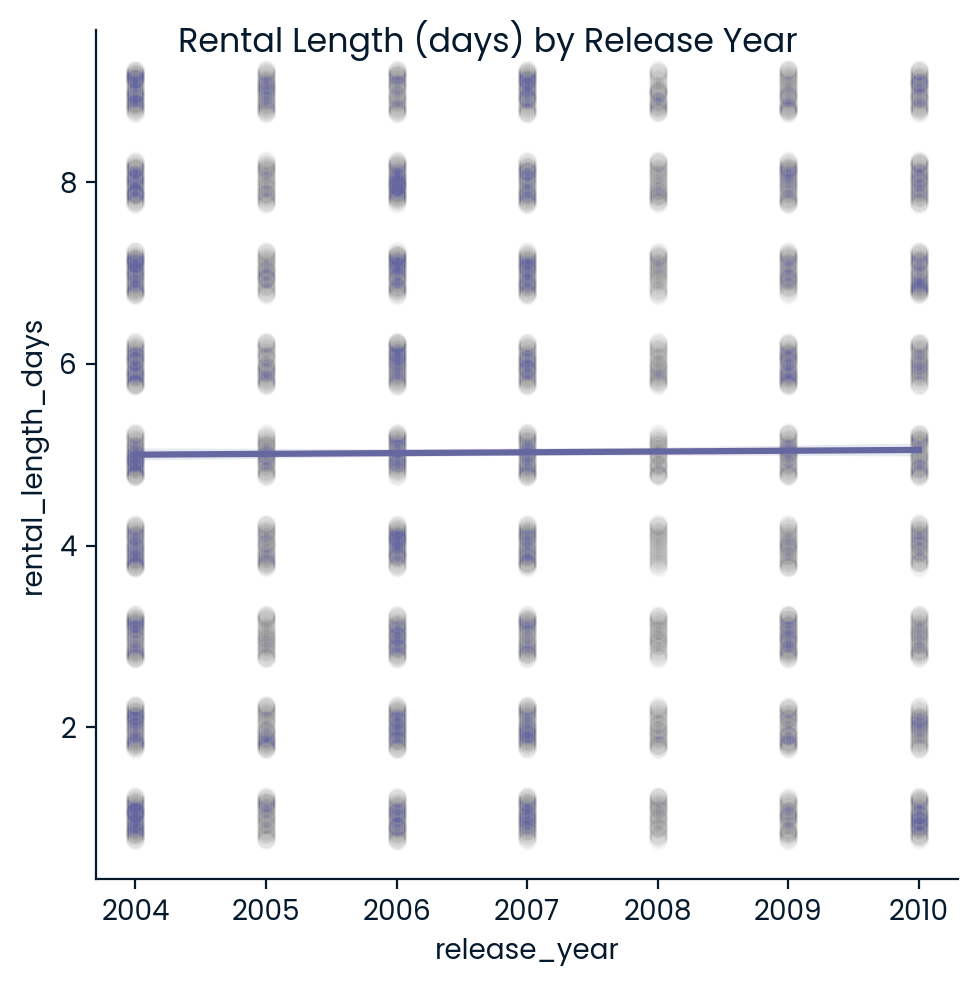

In [118]:
# does release year have a significant impact on rental length? No...
model_release_year = smf.ols('rental_length_days ~ release_year', data=df)
model_release_year_fit = model_release_year.fit()
print(model_release_year_fit.summary())

g_release1 = sns.catplot(x='release_year',
                         y='rental_length_days',
                         data=df,
                         kind='box',
                         hue='release_year')
g_release1.fig.suptitle("Rental Length (days) by Release Year")
plt.show()

g_release2 = sns.lmplot(x='release_year',
                        y='rental_length_days',
                        data=df, scatter_kws={"alpha": 0.005})
g_release2.fig.suptitle("Rental Length (days) by Release Year")
plt.show()

                            OLS Regression Results                            
Dep. Variable:     rental_length_days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3505
Date:                Fri, 08 Aug 2025   Prob (F-statistic):              0.554
Time:                        19:53:00   Log-Likelihood:                -37611.
No. Observations:               15861   AIC:                         7.523e+04
Df Residuals:                   15859   BIC:                         7.524e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0603      0.062     80.982      0.0

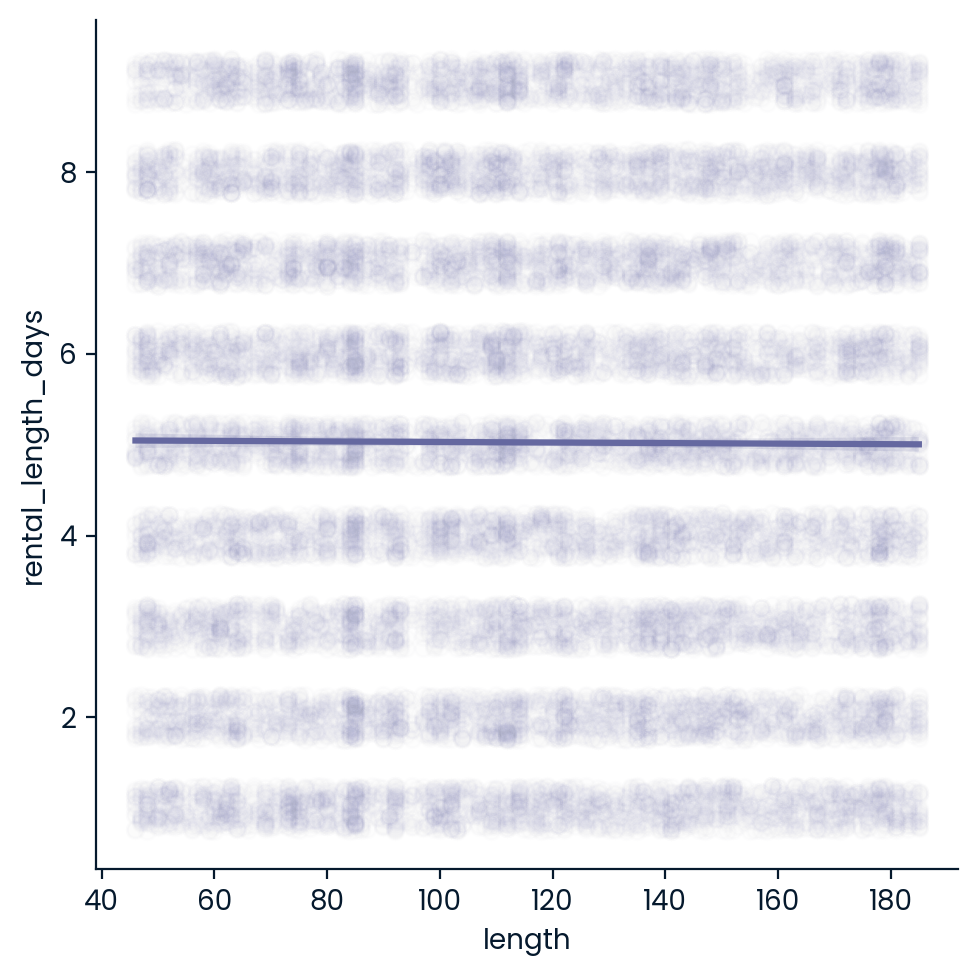

In [119]:
# does length have a significant impact on rental length? No...
model_length = smf.ols('rental_length_days ~ length', data=df)
model_length_fit = model_length.fit()
print(model_length_fit.summary())

sns.lmplot(data=df, x='length', y='rental_length_days', scatter_kws={'alpha':0.01})
plt.show()